In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Correct dataset path (with leading space)
dataset_zip = "/content/drive/MyDrive/NumberPlate Datset with annotation.zip"
extract_path = "/content/data"

# Create extract folder
import os
os.makedirs(extract_path, exist_ok=True)

# Unzip safely
!unzip -o "$dataset_zip" -d "$extract_path"

# List extracted structure
!ls -R $extract_path | head -50


Mounted at /content/drive
Archive:  /content/drive/MyDrive/NumberPlate Datset with annotation.zip
  inflating: /content/data/best.pt   
  inflating: /content/data/images/images/20230327_170242.jpg  
  inflating: /content/data/images/images/20230327_170249.jpg  
  inflating: /content/data/images/images/20230327_170259.jpg  
  inflating: /content/data/images/images/20230418_125454.jpg  
  inflating: /content/data/images/images/20230425_163417.jpg  
  inflating: /content/data/images/images/20230515_095931.jpg  
  inflating: /content/data/images/images/20230515_125709.jpg  
  inflating: /content/data/images/images/20230515_131318.jpg  
  inflating: /content/data/images/images/20230515_133831.jpg  
  inflating: /content/data/images/images/20230516_131859.jpg  
  inflating: /content/data/images/images/20230516_154005.jpg  
  inflating: /content/data/images/images/20230516_154015.jpg  
  inflating: /content/data/images/images/20230516_154022.jpg  
  inflating: /content/data/images/images/2023

In [ ]:
import os, shutil, random


raw_img_dir = "/content/data/images/images"
raw_lbl_dir = "/content/data/yolo_labels"
yolo_dataset = "/content/yolo_dataset"


if os.path.exists(yolo_dataset):
    shutil.rmtree(yolo_dataset)
os.makedirs(f"{yolo_dataset}/images/train", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_dataset}/images/val", exist_ok=True)
os.makedirs(f"{yolo_dataset}/labels/val", exist_ok=True)

all_imgs = [f for f in os.listdir(raw_img_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
print("Total images found:", len(all_imgs))

random.shuffle(all_imgs)
split = int(0.8 * len(all_imgs))   # 80% train, 20% val
train_imgs, val_imgs = all_imgs[:split], all_imgs[split:]


for img in train_imgs:
    shutil.copy(os.path.join(raw_img_dir, img), f"{yolo_dataset}/images/train/")
    lbl = os.path.splitext(img)[0] + ".txt"
    if os.path.exists(os.path.join(raw_lbl_dir, lbl)):
        shutil.copy(os.path.join(raw_lbl_dir, lbl), f"{yolo_dataset}/labels/train/")


for img in val_imgs:
    shutil.copy(os.path.join(raw_img_dir, img), f"{yolo_dataset}/images/val/")
    lbl = os.path.splitext(img)[0] + ".txt"
    if os.path.exists(os.path.join(raw_lbl_dir, lbl)):
        shutil.copy(os.path.join(raw_lbl_dir, lbl), f"{yolo_dataset}/labels/val/")

print(" Dataset restructured")
print("Train images:", len(os.listdir(f'{yolo_dataset}/images/train')))
print("Val images:", len(os.listdir(f'{yolo_dataset}/images/val')))

Total images found: 410
 Dataset restructured
Train images: 328
Val images: 82


Image: /content/data/images/images/20230731_185546.jpg
Label: /content/data/yolo_labels/20230614_150932ll.txt


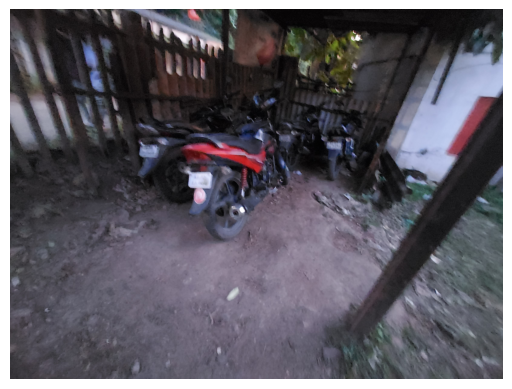

YOLO Annotation:
 0 0.555000 0.229625 0.175333 0.085750
0 0.236000 0.272500 0.074000 0.056500
0 0.222667 0.039875 0.095333 0.070250



In [ ]:
import os, cv2, matplotlib.pyplot as plt

# Correct paths
image_dir = "/content/data/images/images"
label_dir = "/content/data/yolo_labels"

# Pick one sample image
sample_img = os.path.join(image_dir, os.listdir(image_dir)[0])
sample_lbl = os.path.join(label_dir, os.listdir(label_dir)[0])

print("Image:", sample_img)
print("Label:", sample_lbl)

# show image
img = cv2.imread(sample_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# show annotation
with open(sample_lbl, "r") as f:
    print("YOLO Annotation:\n", f.read())


In [ ]:
# PREPROCESSING
#Image Resizing & Normalization

import cv2, os

input_dir = "/content/yolo_dataset/images/train"
output_dir = "/content/preprocessed/train"
os.makedirs(output_dir, exist_ok=True)

for img_name in os.listdir(input_dir):
    img = cv2.imread(os.path.join(input_dir, img_name))
    if img is None:
        continue
    resized = cv2.resize(img, (640, 640))
    norm = resized / 255.0   # normalization
    cv2.imwrite(os.path.join(output_dir, img_name), (norm*255).astype("uint8"))

print(" Resized & normalized images saved in:", output_dir)


 Resized & normalized images saved in: /content/preprocessed/train


In [ ]:
!pip uninstall -y albumentations
!pip install albumentations==1.3.0


Found existing installation: albumentations 2.0.8
Uninstalling albumentations-2.0.8:
  Successfully uninstalled albumentations-2.0.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 10.4 MB/s eta 0:00:00


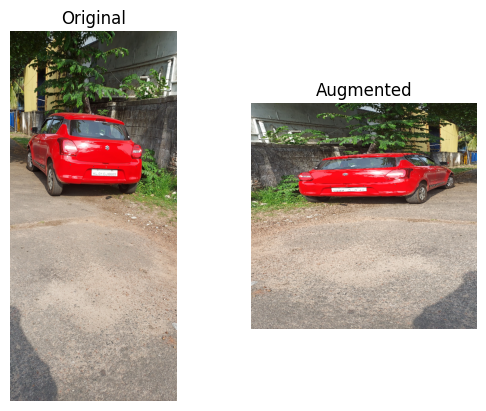

In [ ]:
# Data Augmentation
import albumentations as A
import cv2
from matplotlib import pyplot as plt

transform = A.Compose([
    A.Resize(640, 640),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),  # should now work
    A.HorizontalFlip(p=0.5),
])

img_path = "/content/yolo_dataset/images/train/20230516_154015.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

augmented = transform(image=img)
aug_img = augmented["image"]

plt.subplot(1,2,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(aug_img); plt.title("Augmented"); plt.axis("off")
plt.show()


In [ ]:
# Filtering Poor-Quality Images

import numpy as np

def is_poor_quality(img_path, blur_thresh=100, min_size=200):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return True

    # Blur detection (variance of Laplacian)
    blur_val = cv2.Laplacian(img, cv2.CV_64F).var()
    if blur_val < blur_thresh:
        return True

    # Resolution check
    h, w = img.shape
    if h < min_size or w < min_size:
        return True

    return False

bad_images = []
for img_name in os.listdir(input_dir):
    img_path = os.path.join(input_dir, img_name)
    if is_poor_quality(img_path):
        bad_images.append(img_name)

print(f" Found {len(bad_images)} poor-quality images")
print("Examples:", bad_images[:5])


 Found 40 poor-quality images
Examples: ['20230518_092154.jpg', '20230518_092025.jpg', '20230614_151016ll.jpg', '20230614_151244ll.jpg', '20230624_184914.jpg']


In [ ]:
# Exploratory Data Analysis (EDA)
# Dataset Composition

import os

train_imgs = len(os.listdir("/content/yolo_dataset/images/train"))
val_imgs = len(os.listdir("/content/yolo_dataset/images/val"))
train_lbls = len(os.listdir("/content/yolo_dataset/labels/train"))
val_lbls = len(os.listdir("/content/yolo_dataset/labels/val"))

print(f"Train Images: {train_imgs}, Train Labels: {train_lbls}")
print(f"Val Images: {val_imgs}, Val Labels: {val_lbls}")


Train Images: 328, Train Labels: 92
Val Images: 82, Val Labels: 23


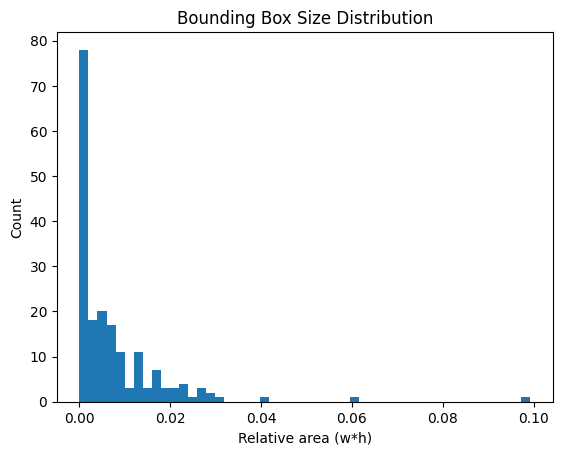

In [ ]:
# Bounding Box Distribution

import matplotlib.pyplot as plt

box_sizes = []
lbl_dir = "/content/yolo_dataset/labels/train"
for lbl_file in os.listdir(lbl_dir):
    with open(os.path.join(lbl_dir, lbl_file)) as f:
        for line in f:
            _, x, y, w, h = map(float, line.strip().split())
            box_sizes.append(w*h)

plt.hist(box_sizes, bins=50)
plt.title("Bounding Box Size Distribution")
plt.xlabel("Relative area (w*h)")
plt.ylabel("Count")
plt.show()

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [ ]:
label_paths = glob('data/yolo_labels/*.txt')
print(f"Found {len(label_paths)} label files.")


Found 116 label files.


100%|██████████| 416/416 [01:15<00:00,  5.47it/s]


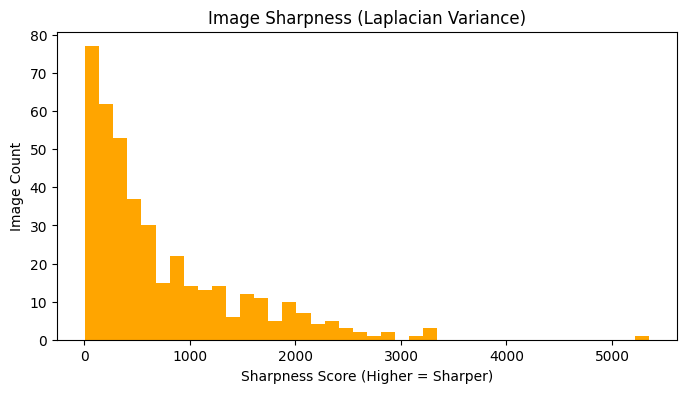

📉 Average Sharpness Score: 726.13
⚠️ Images below threshold (<100) are likely blurry.


In [31]:
# Image Quality Analysis:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set your image directory
image_dir = "data/images/images"

def blur_score(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    return cv2.Laplacian(img, cv2.CV_64F).var()

scores = []
filenames = []

for img_file in tqdm(os.listdir(image_dir)):
    if img_file.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(image_dir, img_file)
        score = blur_score(img_path)
        if score is not None:
            scores.append(score)
            filenames.append(img_file)

# Plot distribution
plt.figure(figsize=(8,4))
plt.hist(scores, bins=40, color='orange')
plt.title('Image Sharpness (Laplacian Variance)')
plt.xlabel('Sharpness Score (Higher = Sharper)')
plt.ylabel('Image Count')
plt.show()

print(f"📉 Average Sharpness Score: {np.mean(scores):.2f}")
print(f"⚠️ Images below threshold (<100) are likely blurry.")


100%|██████████| 416/416 [02:33<00:00,  2.70it/s]


✅ Lighting analysis complete!
                   image  brightness   contrast  saturation
0    20230731_185546.jpg   88.261453  43.786703   39.509382
1    20230714_064115.jpg  128.710269  47.871291   47.126647
2    20230516_154157.jpg  131.398820  65.524898   62.835635
3  20230620_155840ll.jpg  144.238809  55.221656   69.107369
4    20230527_054402.jpg   63.208164  68.326340  141.225840
📄 Report saved as lighting_weather_analysis.csv


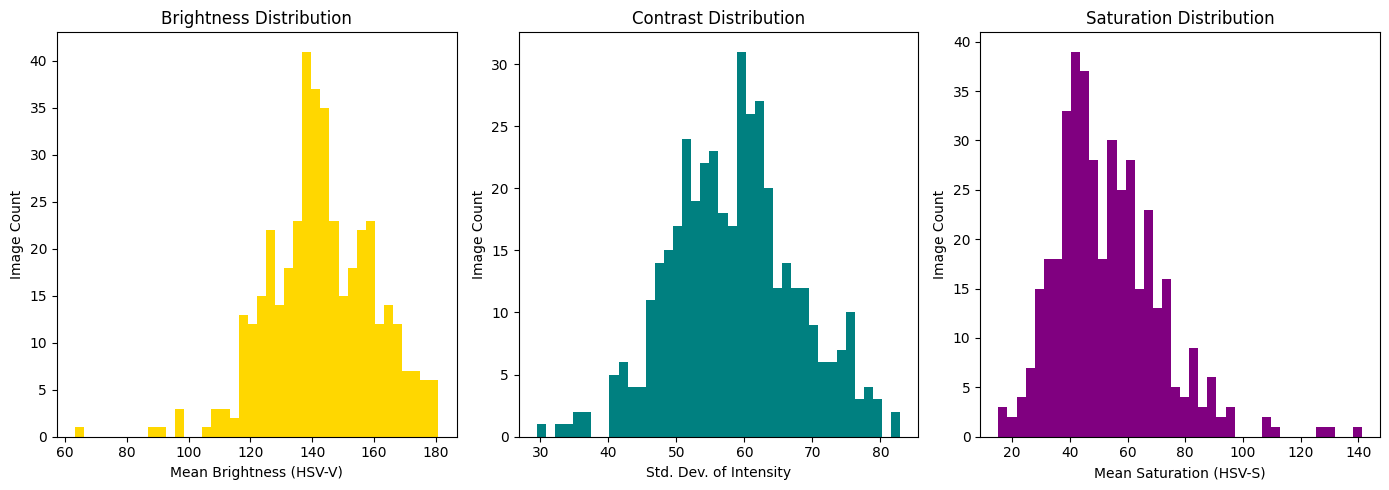


 Summary:
       brightness    contrast  saturation
count  410.000000  410.000000  410.000000
mean   143.069916   58.436082   52.998359
std     16.965125    9.292242   17.972691
min     63.208164   29.454663   15.200808
25%    132.984723   51.968325   40.597742
50%    142.478391   58.799965   50.062064
75%    155.857819   64.064886   62.949787
max    180.915855   82.902507  141.225840


In [32]:
# Lighting Conditions & Weather Variability:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# === PATH TO YOUR IMAGES ===
image_dir = "data/images/images"   # <-- change this if needed

# === STORAGE ===
data = []

# === LOOP THROUGH IMAGES ===
for img_file in tqdm(os.listdir(image_dir)):
    if img_file.endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Convert to HSV for lighting & color analysis
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        brightness = np.mean(hsv[:, :, 2])   # V channel → lighting
        saturation = np.mean(hsv[:, :, 1])   # S channel → weather/color richness
        contrast = np.std(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))  # shadow/glare intensity

        data.append({
            'image': img_file,
            'brightness': brightness,
            'contrast': contrast,
            'saturation': saturation
        })

# === CREATE DATAFRAME ===
df = pd.DataFrame(data)
print("✅ Lighting analysis complete!")
print(df.head())

# === SAVE REPORT ===
df.to_csv("lighting_weather_analysis.csv", index=False)
print("📄 Report saved as lighting_weather_analysis.csv")

# === VISUALIZATIONS ===
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.hist(df['brightness'], bins=40, color='gold')
plt.title('Brightness Distribution')
plt.xlabel('Mean Brightness (HSV-V)')
plt.ylabel('Image Count')

plt.subplot(1,3,2)
plt.hist(df['contrast'], bins=40, color='teal')
plt.title('Contrast Distribution')
plt.xlabel('Std. Dev. of Intensity')
plt.ylabel('Image Count')

plt.subplot(1,3,3)
plt.hist(df['saturation'], bins=40, color='purple')
plt.title('Saturation Distribution')
plt.xlabel('Mean Saturation (HSV-S)')
plt.ylabel('Image Count')

plt.tight_layout()
plt.show()

# === SUMMARY STATS ===
print("\n Summary:")
print(df.describe()[['brightness', 'contrast', 'saturation']])


In [ ]:
# Class Frequency Distribution:

label_files = glob('data/yolo_labels/*.txt')
print(f"Found {len(label_files)} label files to fix...")

for file in label_files:
    new_lines = []
    with open(file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            # If class is not numeric, replace with 0
            if not parts[0].isdigit():
                parts[0] = '0'
            new_lines.append(' '.join(parts))

    # Overwrite the file
    with open(file, 'w') as f:
        f.write('\n'.join(new_lines))

print(" Label files successfully converted to YOLO numeric format!")


Found 116 label files to fix...
 Label files successfully converted to YOLO numeric format!


📦 Total bounding boxes: 234
🧠 Class distribution: {0: 234}


/tmp/ipython-input-3174365637.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=num_boxes, palette="mako")


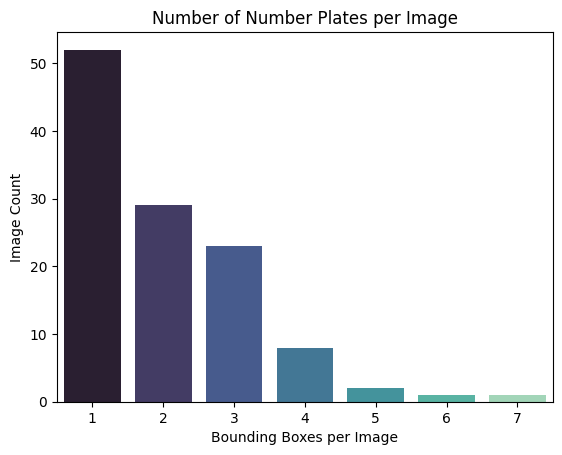

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

num_boxes = []
class_counts = {}

for path in label_paths:
    with open(path, 'r') as f:
        lines = f.readlines()
        num_boxes.append(len(lines))
        for line in lines:
            cls = int(line.strip().split()[0])
            class_counts[cls] = class_counts.get(cls, 0) + 1

print(f"📦 Total bounding boxes: {sum(num_boxes)}")
print(f"🧠 Class distribution: {class_counts}")

# Visualization
sns.countplot(x=num_boxes, palette="mako")
plt.title("Number of Number Plates per Image")
plt.xlabel("Bounding Boxes per Image")
plt.ylabel("Image Count")
plt.show()


In [ ]:
for root, dirs, files in os.walk('data'):
    print(f"📁 {root} — {len(files)} files")
    if len(files) > 0:
        print("  Example files:", files[:5])

📁 data — 1 files
  Example files: ['best.pt']
📁 data/yolo_labels — 116 files
  Example files: ['20230614_150932ll.txt', '20230620_160047ll.txt', '20230614_150831ll.txt', '20230620_160345ll.txt', '20230614_151233ll.txt']
📁 data/images — 0 files
📁 data/images/images — 416 files
  Example files: ['20230731_185546.jpg', '20230714_064115.jpg', '20230516_154157.jpg', '20230620_155840ll.jpg', '20230527_054402.jpg']


In [ ]:
# Augmentation Effects
import albumentations as A
import cv2, os, shutil
from tqdm import tqdm
IMG_DIR = "/content/yolo_dataset/images/train"
LBL_DIR = "/content/yolo_dataset/labels/train"


OUT_IMG_DIR = "/content/yolo_augmented/images/train"
OUT_LBL_DIR = "/content/yolo_augmented/labels/train"

os.makedirs(OUT_IMG_DIR, exist_ok=True)
os.makedirs(OUT_LBL_DIR, exist_ok=True)


transform = A.Compose([
    A.Resize(640, 640),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomResizedCrop(height=640, width=640, scale=(0.8, 1.0), p=0.5)
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))


for img_file in tqdm(os.listdir(IMG_DIR)):
    if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(IMG_DIR, img_file)
    lbl_path = os.path.join(LBL_DIR, img_file.rsplit(".", 1)[0] + ".txt")


    if not os.path.exists(lbl_path):
        continue


    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape


    bboxes, classes = [], []
    with open(lbl_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            bboxes.append([x, y, bw, bh])
            classes.append(int(cls))


    augmented = transform(image=img, bboxes=bboxes, class_labels=classes)
    aug_img, aug_boxes, aug_classes = augmented["image"], augmented["bboxes"], augmented["class_labels"]


    out_img_path = os.path.join(OUT_IMG_DIR, img_file)
    cv2.imwrite(out_img_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))


    out_lbl_path = os.path.join(OUT_LBL_DIR, img_file.rsplit(".", 1)[0] + ".txt")
    with open(out_lbl_path, "w") as f:
        for cls, (x, y, bw, bh) in zip(aug_classes, aug_boxes):
            f.write(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

print(" Augmentation complete. Saved to /content/yolo_augmented")

100%|██████████| 328/328 [00:10<00:00, 30.80it/s]

 Augmentation complete. Saved to /content/yolo_augmented


In [ ]:
# Merge aug with original :
import os, shutil, random


orig_root = "/content/yolo_dataset"
aug_root  = "/content/yolo_augmented"
final_root = "/content/yolo_dataset_final"


for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(final_root, sub), exist_ok=True)

def copy_files(src_img_dir, src_lbl_dir, dest_img_dir, dest_lbl_dir):
    if not os.path.exists(src_img_dir): return
    for img in os.listdir(src_img_dir):
        if not (img.endswith(".jpg") or img.endswith(".png")):
            continue
        lbl = img.rsplit(".",1)[0] + ".txt"
        shutil.copy(os.path.join(src_img_dir, img), os.path.join(dest_img_dir, img))
        if os.path.exists(os.path.join(src_lbl_dir, lbl)):
            shutil.copy(os.path.join(src_lbl_dir, lbl), os.path.join(dest_lbl_dir, lbl))


copy_files(os.path.join(orig_root, "images/train"), os.path.join(orig_root, "labels/train"),
           os.path.join(final_root, "images/train"), os.path.join(final_root, "labels/train"))
copy_files(os.path.join(orig_root, "images/val"), os.path.join(orig_root, "labels/val"),
           os.path.join(final_root, "images/train"), os.path.join(final_root, "labels/train"))  # put val together for resplit


copy_files(os.path.join(aug_root, "images/train"), os.path.join(aug_root, "labels/train"),
           os.path.join(final_root, "images/train"), os.path.join(final_root, "labels/train"))

print(" Original + Augmented merged into", final_root)


train_img_dir = os.path.join(final_root, "images/train")
val_img_dir   = os.path.join(final_root, "images/val")
train_lbl_dir = os.path.join(final_root, "labels/train")
val_lbl_dir   = os.path.join(final_root, "labels/val")


all_imgs = os.listdir(train_img_dir)

if len(all_imgs) < 2:
    print(f" Not enough images to split! Found only {len(all_imgs)} images in train.")
    print(" Keeping everything in train (no validation set).")
else:
    val_count = max(1, int(len(all_imgs) * 0.2))  # 20% validation
    val_count = min(len(all_imgs)-1, val_count)   # ensure not larger than population
    val_samples = random.sample(all_imgs, val_count)

    for img in val_samples:
        shutil.move(os.path.join(train_img_dir, img), os.path.join(val_img_dir, img))
        lbl = img.rsplit(".",1)[0] + ".txt"
        if os.path.exists(os.path.join(train_lbl_dir, lbl)):
            shutil.move(os.path.join(train_lbl_dir, lbl), os.path.join(val_lbl_dir, lbl))

print(" Final dataset split complete")
print("Train images:", len(os.listdir(train_img_dir)))
print("Val images:", len(os.listdir(val_img_dir)))


 Original + Augmented merged into /content/yolo_dataset_final
 Final dataset split complete
Train images: 328
Val images: 82


In [ ]:

# Dataset creation:
yaml_path = "/content/yolo_dataset_final/dataset.yaml"

dataset_yaml = f"""
train: {os.path.abspath('/content/yolo_dataset_final/images/train')}
val: {os.path.abspath('/content/yolo_dataset_final/images/val')}

nc: 1
names: ['number_plate']
"""


with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(" dataset.yaml created at:", yaml_path)


 dataset.yaml created at: /content/yolo_dataset_final/dataset.yaml


In [ ]:
!cat /content/yolo_dataset_final/dataset.yaml


train: /content/yolo_dataset_final/images/train
val: /content/yolo_dataset_final/images/val

nc: 1
names: ['number_plate']


In [ ]:
# MODEL TRAINING:

!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import torch


#  Load a pretrained YOLOv8 model
model = YOLO("yolov8s.pt")

device = "0" if torch.cuda.is_available() else "cpu"
print("Training on:", "GPU" if device=="0" else "CPU")

#  Train with fine-tuned hyperparameters
results = model.train(
    data="/content/yolo_dataset_final/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=0.001,
    optimizer="Adam",
    device=device,
    workers=2,
    cos_lr=True,
    patience=10,
    mosaic=1.0
)

#  Save trained weights path
print(" Training complete. Best model saved at:", model.ckpt_path)

Training on: GPU
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_dataset_final/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=Adam, overlap_mask=True, patience=10, perspecti

 Evaluating model on validation set...
Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1895.2±524.4 MB/s, size: 3482.7 KB)
val: Scanning /content/yolo_dataset_final/labels/val.cache... 21 images, 61 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 82/82 42.2Kit/s 0.0s
val: /content/yolo_dataset_final/images/val/20230327_170249.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154031.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154219.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154223.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230516_154343.jpg: corrupt JPEG restored and saved
val: /content/yolo_dataset_final/images/val/20230518_065959.jpg: corrupt JPEG restored

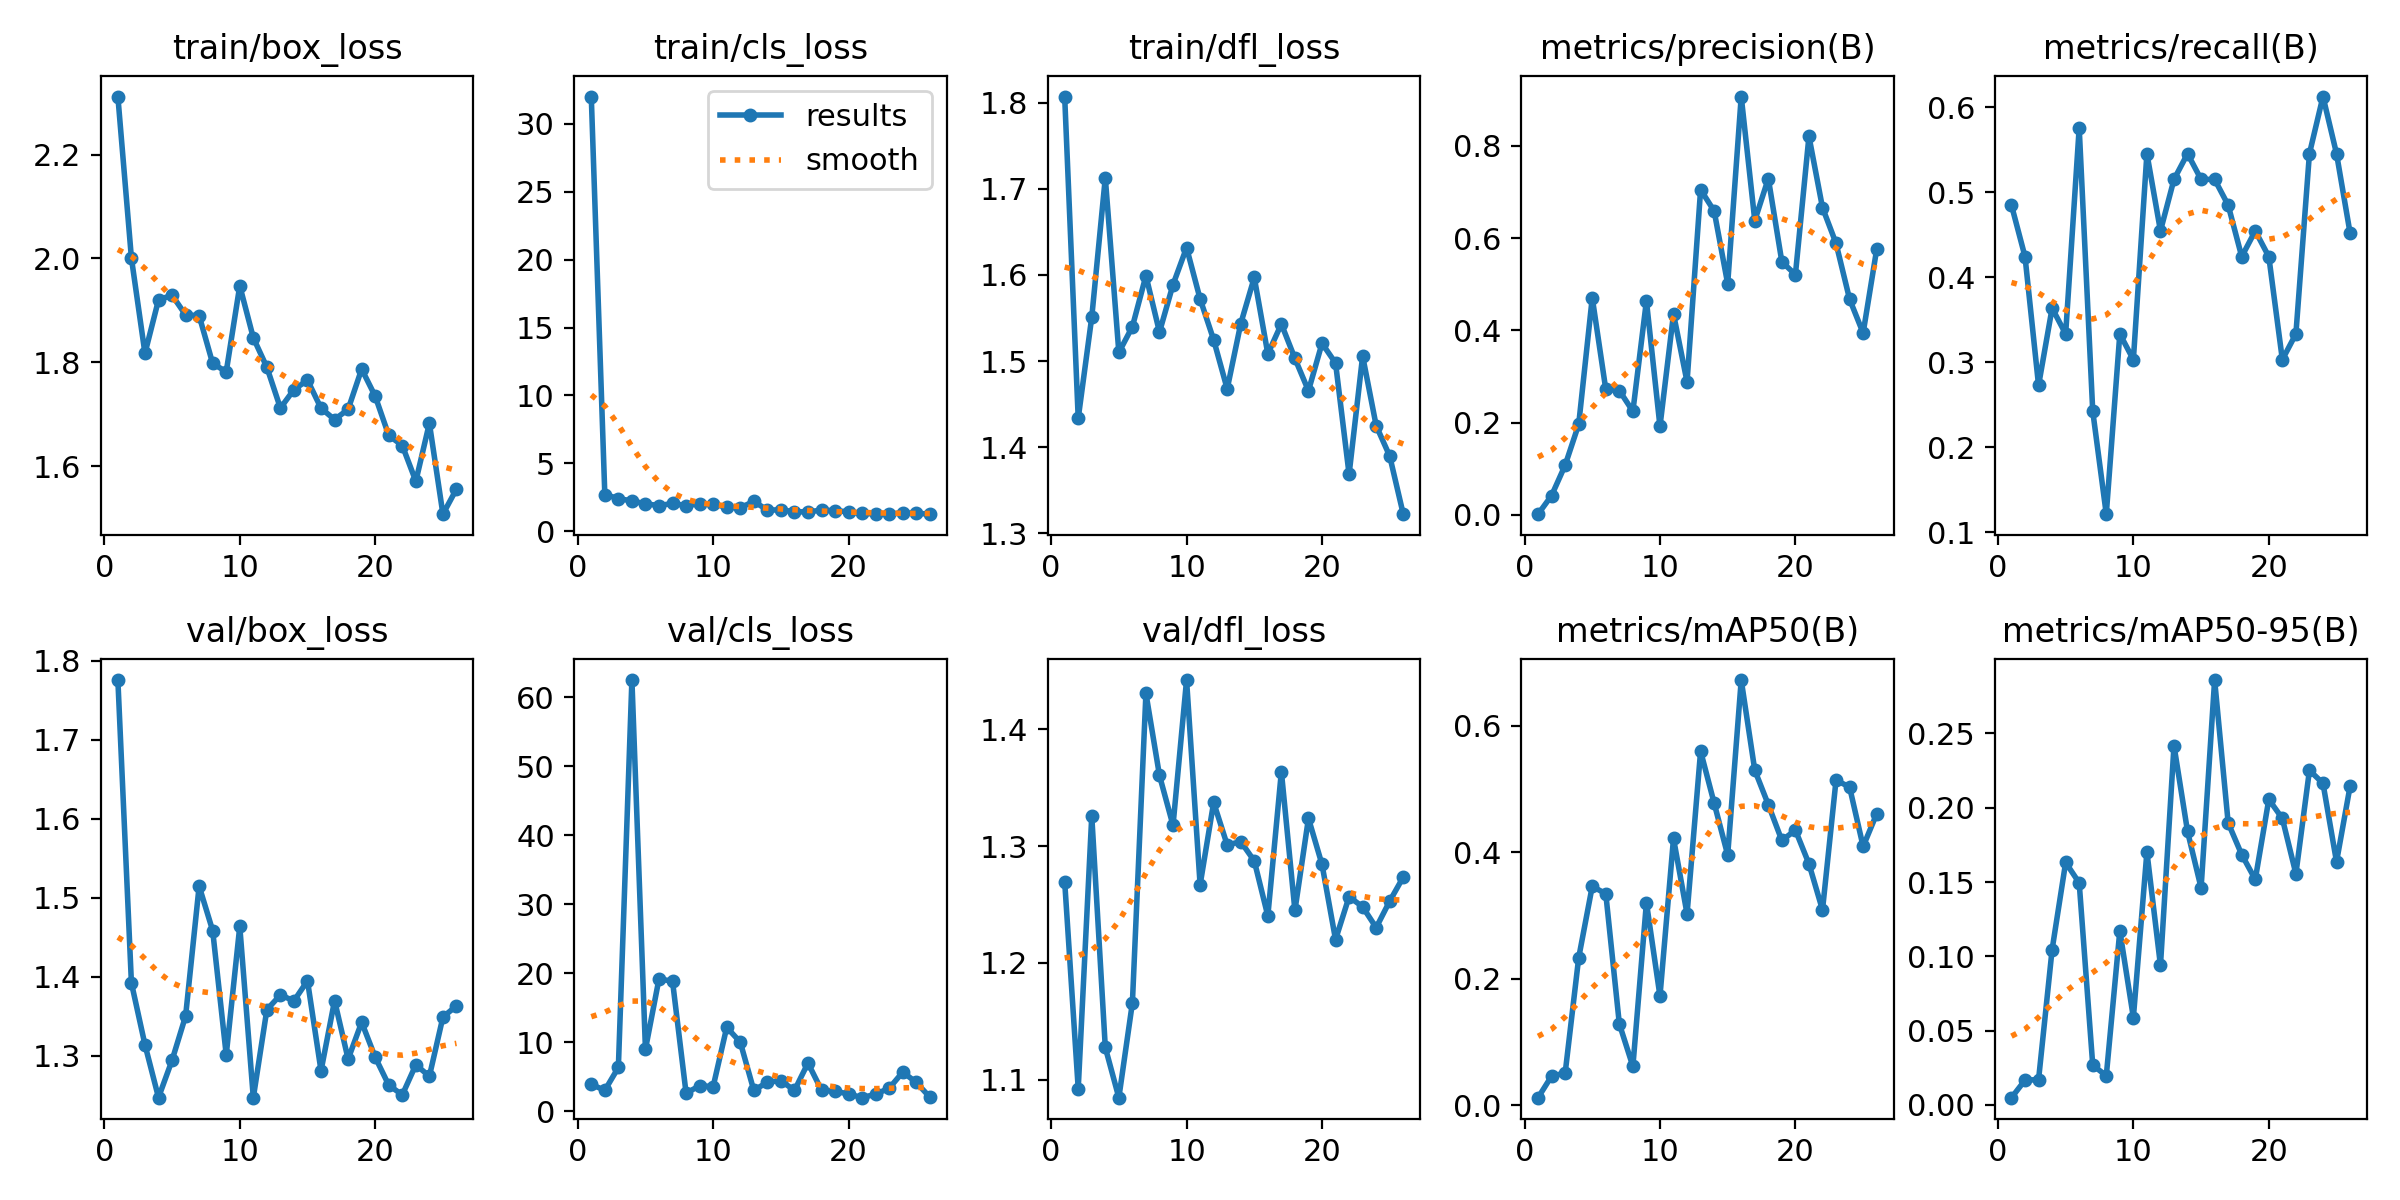

 Running inference on random validation images...

image 1/1 /content/yolo_dataset_final/images/val/20230714_172220.jpg: 480x640 (no detections), 68.5ms
Speed: 6.6ms preprocess, 68.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict
 Prediction saved for 20230714_172220.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230518_065959.jpg: 640x288 (no detections), 68.4ms
Speed: 3.3ms preprocess, 68.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 288)
Results saved to /content/runs/detect/predict
 Prediction saved for 20230518_065959.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230518_092143.jpg: 288x640 (no detections), 65.1ms
Speed: 3.0ms preprocess, 65.1ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 640)
Results saved to /content/runs/detect/predict
 Prediction saved for 20230518_092143.jpg

image 1/1 /content/yolo_dataset_final/images/val/20240201_165141.jpg: 288x640 (no det

In [ ]:

# EVALUATION:
from ultralytics import YOLO
from IPython.display import Image, display
import os, random

#  Load the Model
model = YOLO("runs/detect/train2/weights/best.pt")


#  MODEL EVALUATION
print(" Evaluating model on validation set...")
metrics = model.val()
print(metrics)


#  VISUALIZE TRAINING

print("📈 Showing training curves...")
results_img = "runs/detect/train2/results.png"
if os.path.exists(results_img):
    display(Image(filename=results_img))
else:
    print("No results.png found, maybe training was interrupted.")

#  INFERENCE ON SAMPLE IMAGES

print(" Running inference on random validation images...")

val_dir = "/content/yolo_dataset_final/images/val"
sample_imgs = random.sample(os.listdir(val_dir), min(5, len(os.listdir(val_dir))))

for img_file in sample_imgs:
    img_path = os.path.join(val_dir, img_file)
    results = model.predict(source=img_path, conf=0.4, save=True)
    print(f" Prediction saved for {img_file}")

print("\n Predictions saved under: runs/detect/predict/")


# SAVE BEST MODEL TO GOOGLE DRIVE

print(" Saving the best model to Google Drive...")
drive_path = "/content/drive/MyDrive/best_numberplate_model.pt"
!cp runs/detect/train2/weights/best.pt {drive_path}
print(f" Best model copied to {drive_path}")


In [ ]:
from google.colab import files
files.download("runs/detect/train2/weights/best.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Post processing:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 30.5 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import easyocr
import os
import matplotlib.pyplot as plt

# Load trained YOLO model
model = YOLO("runs/detect/train2/weights/best.pt")


val_dir = "/content/yolo_dataset_final/images/val"


test_img = os.path.join(val_dir, os.listdir(val_dir)[0])  # first image in val
print("Using test image:", test_img)


results = model.predict(test_img, conf=0.4)

# Load image
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Extract bounding boxes
for r in results:
    for box in r.boxes.xyxy:  # x1, y1, x2, y2
        x1, y1, x2, y2 = map(int, box)
        plate_region = img[y1:y2, x1:x2]

        # Run OCR on detected plate
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(plate_region)

        print(" OCR Result:", ocr_result)

        # Show detected plate
        plt.imshow(plate_region)
        plt.title("Detected Plate Region")
        plt.axis("off")
        plt.show()


Using test image: /content/yolo_dataset_final/images/val/20230731_185546.jpg

image 1/1 /content/yolo_dataset_final/images/val/20230731_185546.jpg: 480x640 (no detections), 21.8ms
Speed: 8.3ms preprocess, 21.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
